>[Part 2: Implementation](#scrollTo=lf0fuKeLsnwS)

>>[A: Setting Environment](#scrollTo=nqV4WFx4sxuI)

>>[B: Random Agent](#scrollTo=I7PEGjaR0rGW)

>>[Q-Learning Policy](#scrollTo=l_9BQMHK-R6t)



# Part 2: Implementation

In [1]:
!pip install -q gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.7 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
from IPython.display import clear_output, display
from matplotlib import pyplot as plt

In [38]:
def plotter(x, y, label, title, lower_bound=None, upper_bound=None, window=30):
  weight = np.repeat(1.0, window)/window
  smas = np.convolve(y,weight,'valid')

  plt.figure(figsize=(8,6))
  plt.plot(x, y, label=label)
  plt.plot(smas, label=f"Moving Avg (window={window})")
  plt.fill_between(x, lower_bound, upper_bound, alpha=0.5, label=" 95% Confidence Interval")
  plt.xlabel("Episode")
  plt.ylabel(label)
  plt.title(title)
  plt.grid(True)
  plt.legend()
  plt.show()

## A: Setting Environment

In [ ]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="rgb_array")
trigger = lambda t: t % 500 == 0
env = RecordVideo(env, video_folder="./Random_FrozenLake", episode_trigger=trigger)

## B: Random Agent

In [ ]:
num_epochs = 10
num_episodes = 1500
epoch_rewards = []

for epoch in range(num_epochs):
  episodes_rewards = []
  for episode in range(num_episodes):
    episode_reward = 0

    state, info = env.reset(seed=456)
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)

    episode_reward += reward
    while not terminated and not truncated:
      action = env.action_space.sample()
      state, reward, terminated, truncated, info = env.step(action)

      episode_reward+=reward

    clear_output(wait=True)
    episodes_rewards.append(episode_reward)

  epoch_rewards.append(episodes_rewards)

env.close()
clear_output(wait=False)

Moviepy - Building video /content/Random_FrozenLake/rl-video-episode-15000.mp4.
Moviepy - Writing video /content/Random_FrozenLake/rl-video-episode-15000.mp4



Moviepy - Done !
Moviepy - video ready /content/Random_FrozenLake/rl-video-episode-15000.mp4


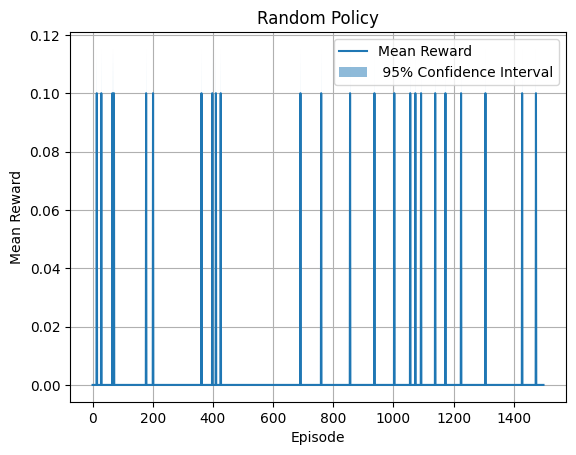

In [ ]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Random Policy", mean_reward_lbound, mean_reward_ubound)

## Q-Learning Policy

In [17]:
class QLearner:
    def __init__(self, env, decay_alpha=False):
        self.env = env
        num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.q_table = np.zeros((num_states, self.num_actions))
        self.decay_alpha = decay_alpha


    def update_q_table(self, state, next_state, reward, action):
        self.q_table[state][action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state,:]) - self.q_table[state][action])

    def behavior_policy(self, state):

        if np.random.uniform() <= self.epsilon:
          action = self.env.action_space.sample()
        else:
          action = self.target_policy(state)

        return action

    def target_policy(self, state):
        max_indices = np.where(self.q_table[state] == np.max(self.q_table[state]))[0]
        return np.random.choice(max_indices)

    def update_param(self):
        self.epsilon = max(self.epsilon * self.xi, 0.01)
        if self.decay_alpha:
          self.alpha *= self.xi

    def reset(self, alpha=0.1, gamma=0.9, epsilon=0.9, xi=0.999, seed=456):
        np.random.seed(seed)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.xi = xi

**Training**

In [19]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
agent = QLearner(env)

In [20]:
num_epochs = 5
num_episodes = 10000
max_steps = 300
epoch_rewards = []

for epoch in range(num_epochs):
  episodes_rewards = []
  agent.reset(alpha=0.8, gamma=0.99, epsilon=1, xi=0.999, seed=456)
  for episode in range(num_episodes):
    episode_reward = 0

    obs, _ = env.reset()
    action = agent.behavior_policy(obs)

    for _ in range(max_steps):

      next_obs, reward, terminated, truncated, info = env.step(action)
      agent.update_q_table(obs, next_obs, reward, action)
      obs = next_obs
      action = agent.behavior_policy(obs)
      episode_reward += reward
      if terminated or truncated:
        print('epoch:', epoch+1 ,'episode:', episode+1, 'sum_of_rewards_for_episode:', episode_reward, 'final reward:', reward, 'epsilon:', agent.epsilon)
        break

    agent.update_param()
    episodes_rewards.append(episode_reward)
    clear_output(wait=True)


  epoch_rewards.append(episodes_rewards)

env.close()

epoch: 5 episode: 10000 sum_of_rewards_for_episode: 1.0 final reward: 1.0 epsilon: 0.01


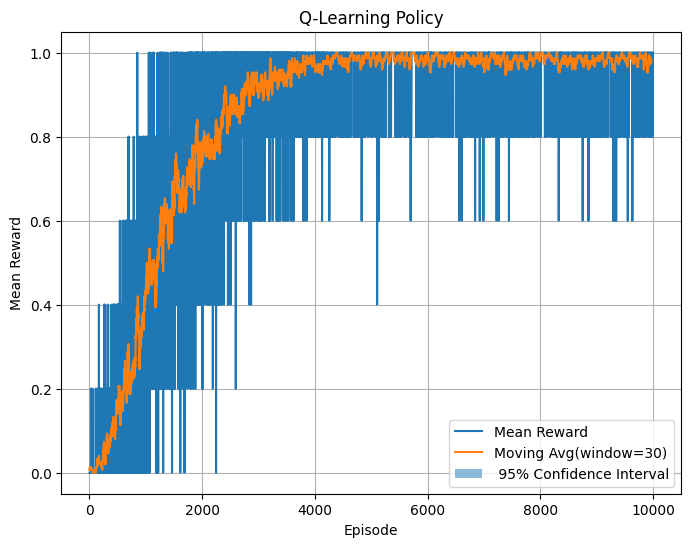

In [39]:
mean_rewards = np.mean(epoch_rewards, axis=0)
mean_rewards_std = np.std(epoch_rewards, axis=0)
mean_reward_ubound = mean_rewards + 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))
mean_reward_lbound = mean_rewards - 1.96 * mean_rewards_std / np.sqrt(len(mean_rewards))

plotter(range(len(mean_rewards)), mean_rewards, "Mean Reward","Q-Learning Policy", mean_reward_lbound, mean_reward_ubound)

**Test**

In [29]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array")
trigger = lambda t: t % 1 == 0
env = RecordVideo(env, video_folder="./Q_FrozenLake", episode_trigger=trigger)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/Q_FrozenLake folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [30]:
num_episodes = 10
max_steps = 300


for episode in range(num_episodes):

  obs, _ = env.reset()
  action = agent.behavior_policy(obs)

  for _ in range(max_steps):

    next_obs, reward, terminated, truncated, info = env.step(action)
    obs = next_obs
    action = agent.behavior_policy(obs)

    if terminated or truncated:
      print('episode:', episode+1, 'final reward:', reward)
      break

  clear_output(wait=True)

env.close()

Moviepy - Building video /content/Q_FrozenLake/rl-video-episode-9.mp4.
Moviepy - Writing video /content/Q_FrozenLake/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/Q_FrozenLake/rl-video-episode-9.mp4
episode: 10 final reward: 1.0
